In [1]:
#%%capture
%load_ext line_profiler
%matplotlib inline


# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [2]:
%%time
import os.path
import json

num_runs = 1

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}


num_timesteps = 24 * 5
simulation_parameters = {
    'T': range(num_timesteps),
    'N': num_runs,
    'M': params
}


# initialized_conditions = {}

if not os.path.exists('./last-run.json'):
    initialized_conditions = utils.initialize(market_settings, initial_conditions)
else:
    with open('./last-run.json', 'r') as f:
        initialized_conditions = json.load(f)
        initialized_conditions['s']['network'] = utils.fromDICT(initialized_conditions['s']['network'])
        initialized_conditions['s']['day-number'] = 6
        

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'participantPool': policies.participant_pool_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_participant_pool
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    {
        'policies': {},
        'variables':{
            's': state_updates.save_file
        }
    }
    #     speculators # folks speculating on clover coin price
]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f15a1a78b70>]
CPU times: user 34min 3s, sys: 33.8 s, total: 34min 37s
Wall time: 34min 36s


In [3]:
%%time
# {'s': {'bc-balance': 40, 'bc-totalSupply': 30297.222282697643, 'symmetries': {'hasSymmetry': 0, 'rotSym': 0, 'y0Sym': 0, 'x0Sym': 0, 'xySym': 0, 'xnySym': 0}, 'network': <networkx.classes.digraph.DiGraph object at 0x7feb94401eb8>, 'players': [61728968314424, 293889188073290, 226408724277593, 472925374878931, 638758537652366, 344097444779201, 129303744057255, 316855034068104, 215183806154351, 232027941686814], 'miners': [895282972085115], 'bank': 325998228332377, 'clovers': []}}
def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        substep = row['substep']
        run = row['run']
        s = row['s']
        g = s['network']
        new_cols = {}

        
        miners = utils.get_nodes_by_type(s, 'miner')
        players = utils.get_nodes_by_type(s, 'player')
        clovers = utils.get_nodes_by_type(s, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward

        new_cols['miners'] = len(miners)
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(s['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
#         res.pop('hasSymmetry')
        res.pop('symmetries')
        res.pop('bank')
        res.pop('s')
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

full_df = to_df(raw_result)

# adding new useful columns for graphing
full_df['coin-price'] = utils.calculateCurrentPrice(
    (full_df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (full_df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

full_df['market-cap'] = full_df['coin-price'] * full_df['bc-totalSupply'] * 250

full_df

CPU times: user 2.72 s, sys: 0 ns, total: 2.72 s
Wall time: 2.71 s


In [4]:
_s = raw_result.pop()['s']
_g = _s['network']
def make_clover(cloverId):
    clover = _g.node[cloverId]
    clover['_id'] = cloverId
    return clover
clover_df = pd.DataFrame(map(make_clover, _s['clovers']))
pd.concat([clover_df.head(5), clover_df.tail(5)])

,_id,hasSymmetry,owner_type,pretty,price,reward,rotSym,step,type,x0Sym,xnySym,xySym,y0Sym
0,544039309316023,True,bank,0.000000,13.750000,1.275000,True,2,clover,False,False,False,False
1,444284056208109,True,bank,0.000000,25.000000,2.400000,True,2,clover,False,False,False,False
2,845607825838608,True,bank,0.000000,29.375000,2.837500,True,2,clover,False,False,False,False
3,199175526551379,True,bank,0.000000,28.500000,2.750000,True,2,clover,False,False,False,False
4,627222040610654,True,bank,0.000000,24.166667,2.316667,True,2,clover,False,False,False,False
5314,690900616378671,True,player,0.000000,0.000000,0.123331,False,192,clover,False,True,False,False
5315,603171707635105,True,player,1.937528,0.000000,0.123331,False,192,clover,False,True,False,False
5316,384279615318215,True,player,1.788902,0.000000,0.140663,False,192,clover,False,False,True,False
5317,768998872358378,True,player,1.795192,0.000000,0.140661,False,192,clover,False,False,True,False
5318,606596700206715,True,player,1.420379,0.000000,0.140659,False,192,clover,False,False,True,False


In [5]:
df = full_df[full_df['substep'] == 0].append(full_df[full_df['substep'] == len(partial_state_update_blocks)]) # after player policy
df

,bankClovers,bc-balance,bc-totalSupply,clovers,day-number,hasSymmetry,miners,players,reward-rotSym,reward-x0Sym,...,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price,market-cap
0,1827,38.931386,30485.942729,3308,6,55235,30,77,1.437818,0.491535,...,1883,1,0,0,5510,21857,19343,5583,0.001654,12604.334897
5,1848,38.893280,30493.052400,3329,6,55790,30,77,1.436142,0.492680,...,1904,1,5,1,5552,22077,19537,5646,0.001653,12599.909238
10,1878,38.852164,30500.544812,3368,6,56365,30,77,1.428527,0.492464,...,1934,1,5,2,5612,22293,19746,5698,0.001652,12595.074252
15,1889,38.822796,30491.366462,3385,6,56927,30,77,1.434584,0.492624,...,1945,1,5,3,5666,22520,19948,5754,0.001651,12587.022945
20,1904,38.784072,30474.411567,3413,6,57510,30,77,1.438271,0.492827,...,1960,1,5,4,5722,22741,20166,5819,0.001651,12574.874973
25,1920,38.800426,30491.285231,3442,6,58082,30,77,1.440769,0.492292,...,1976,1,5,5,5785,22968,20376,5862,0.001651,12583.076809
30,1936,38.787514,30492.011094,3469,6,58668,30,77,1.442904,0.491484,...,1993,1,5,6,5853,23199,20572,5925,0.001650,12581.043572
35,1953,38.753498,30495.924785,3486,6,59274,33,85,1.445351,0.491561,...,2010,1,5,7,5912,23430,20789,5990,0.001650,12576.318928
40,1974,38.701926,30489.123055,3512,6,59890,33,85,1.445202,0.490341,...,2031,1,5,8,5988,23669,20975,6069,0.001648,12565.131736
45,1994,38.681236,30491.826837,3544,6,60511,33,85,1.445858,0.490884,...,2051,1,5,9,6043,23913,21190,6140,0.001648,12562.359673


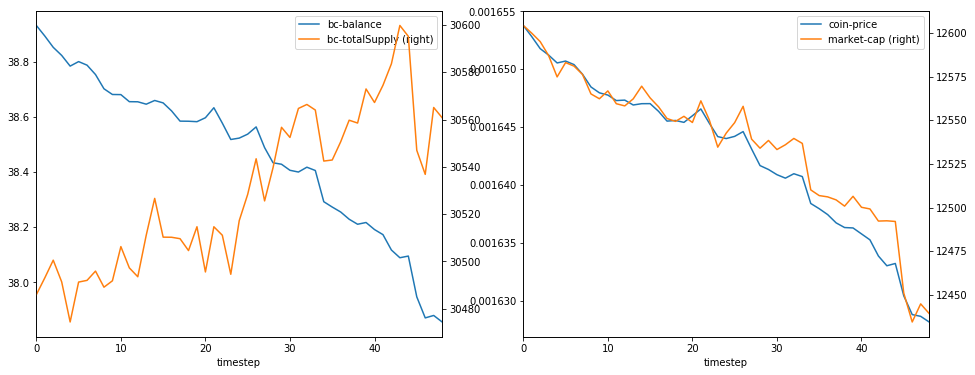

In [6]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[1])
else:
    for run in range(0,num_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[run,1])

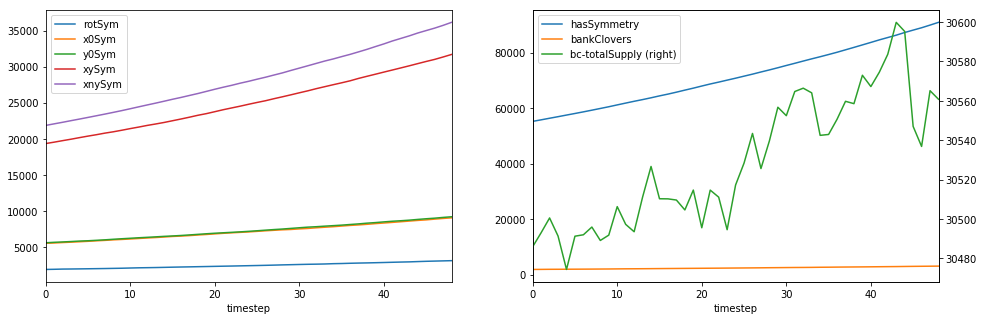

In [7]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', ['hasSymmetry','bankClovers'], ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

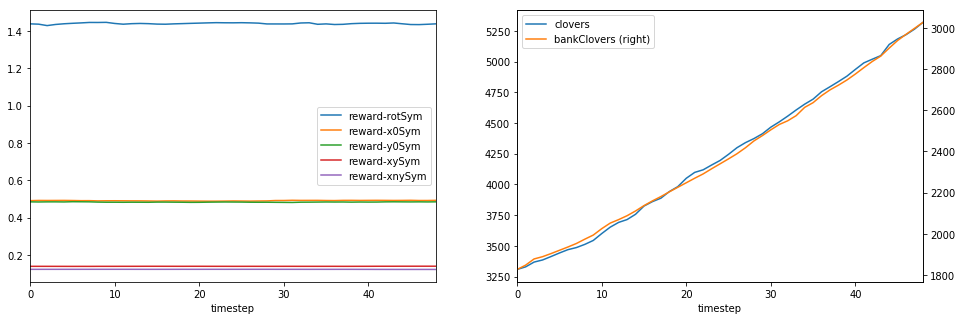

In [8]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

if num_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', 'clovers', ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df.plot('timestep','bankClovers',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,num_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', 'clovers', ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bankClovers',secondary_y=True, ax=axs[row_idx,1])

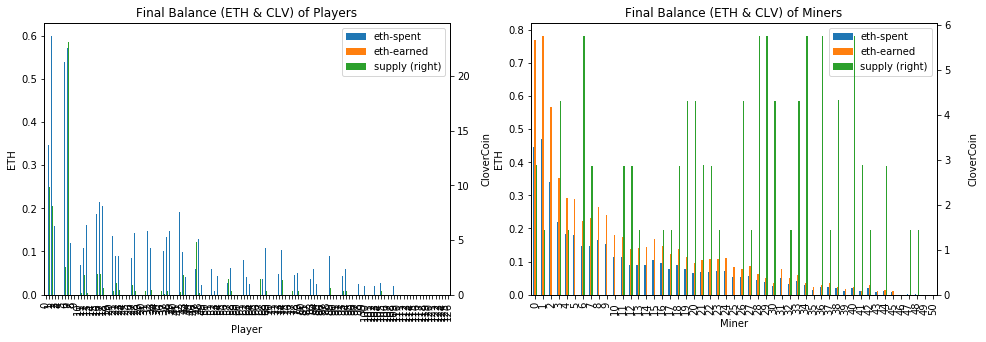

In [9]:
final_state = raw_result[-1]['s']
g = final_state['network']
miners = utils.get_nodes_by_type(final_state, 'miner')
players = utils.get_nodes_by_type(final_state, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(16,(row_height*num_runs)))
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if num_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if num_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
        pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])

Text(0.5, 51.0, 'Timestep')

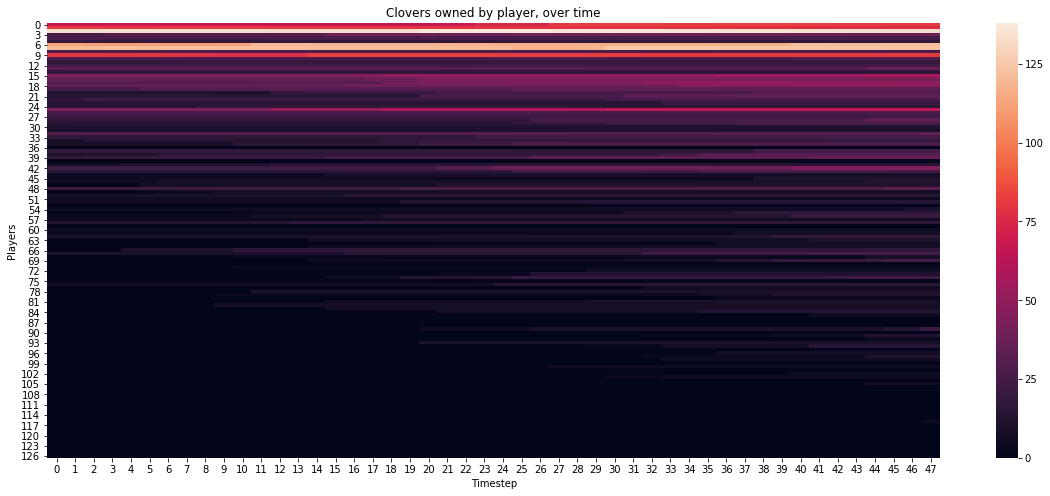

In [10]:
players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')
affinities = np.empty((len(players), num_timesteps))
# print("affinities", affinities)
substeps = len(partial_state_update_blocks)
for i_ind in range(len(players)):
    nodeId = players[i_ind]
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        if g.has_node(nodeId):
            affinities[i_ind][j_ind] = len(list(g.successors(nodeId)))
        else:
            affinities[i_ind][j_ind] = 0

dims = (20, 8)
# adjust the dimensions

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

In [ ]:
players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')

affinities = np.empty((len(players), num_timesteps))
substeps = len(partial_state_update_blocks)

for i_ind in range(len(players)):
    playerId = players[i_ind]
    for j_ind in range(num_timesteps):
        g = raw_result[j_ind*substeps]['s']['network']
        # this line below sets the value to determine the color
        # for a given player/timestep combination
        # len(list(g.successors(i_ind))) => owned clovers by this user
        if g.has_node(playerId):
            affinities[i_ind][j_ind] = g.nodes[playerId]['is_active']
        else:
            affinities[i_ind][j_ind] = False

dims = (20, 5)

fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            cbar=True, ax=ax)

plt.title('Clovers owned by player, over time')
plt.ylabel('Players')
plt.xlabel('Timestep')

In [ ]:
def test_function():
    step = 1
    s = raw_result[step]

    _input = policies.miner_policy([params], step, None, s)
    s['s'] = state_updates.update_state_miner_policy(None, step, None, s, _input)[1]

    _input = policies.player_policy([params], step, None, s)
    s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    
    _input = policies.market_activity_policy([params], step, None, s)
    s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    return s


# %lprun -f utils.processBuysAndSells test_function()
%lprun \
-f state_updates.updateActivePlayers \
test_function()